# Intervention


In [1]:
from measureLM import visualizing, decoding

import torch
import transformer_lens


model = transformer_lens.HookedTransformer.from_pretrained("gpt2-medium").to("cpu")
model.tokenizer.pad_token = model.tokenizer.eos_token

Using pad_token, but it is not set yet.


Loaded pretrained model gpt2-medium into HookedTransformer
Moving model to device:  cpu


Using pad_token, but it is not set yet.


Loaded pretrained model gpt2-medium into HookedTransformer
Moving model to device:  cpu


Using pad_token, but it is not set yet.


Loaded pretrained model gpt2-medium into HookedTransformer
Moving model to device:  cpu

prompt 0
layer 0: [(0.0002, 'Paris'), (0.0002, 'France'), (0.0007, 'Poland'), (0.0003, 'Warsaw')]
layer 1: [(0.0003, 'Paris'), (0.0002, 'France'), (0.0004, 'Poland'), (0.0005, 'Warsaw')]
layer 2: [(0.0003, 'Paris'), (0.0002, 'France'), (0.0004, 'Poland'), (0.0004, 'Warsaw')]
layer 3: [(0.0005, 'Paris'), (0.0002, 'France'), (0.0007, 'Poland'), (0.0008, 'Warsaw')]
layer 4: [(0.001, 'Paris'), (0.0004, 'France'), (0.0005, 'Poland'), (0.0007, 'Warsaw')]
layer 5: [(0.0007, 'Paris'), (0.0003, 'France'), (0.0003, 'Poland'), (0.0005, 'Warsaw')]
layer 6: [(0.0012, 'Paris'), (0.0003, 'France'), (0.0004, 'Poland'), (0.0004, 'Warsaw')]
layer 7: [(0.0016, 'Paris'), (0.0008, 'France'), (0.0016, 'Poland'), (0.0012, 'Warsaw')]
layer 8: [(0.0012, 'Paris'), (0.0012, 'France'), (0.0022, 'Poland'), (0.0019, 'Warsaw')]
layer 9: [(0.0081, 'Paris'), (0.0023, 'France'), (0.004, 'Poland'), (0.0015, 'Warsaw')]
layer 10: [(0.

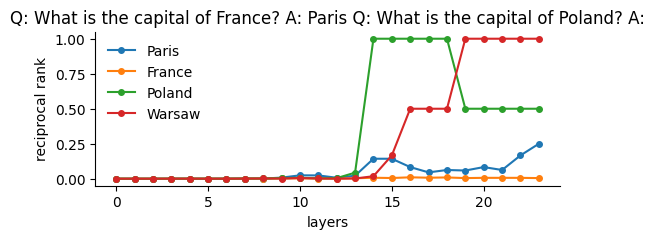

In [107]:
## decoder-only model____________
model = transformer_lens.HookedTransformer.from_pretrained("gpt2-medium").to("cpu")
model.tokenizer.pad_token = model.tokenizer.eos_token

token_candidates = ["Paris", "France", "Poland", "Warsaw"]
prompts = ["Q: What is the capital of France? A: Paris Q: What is the capital of Poland? A:"]

## encoding
logits, activs, tokens = decoding.encode(prompts, model)
layer_scores = decoding.early_decoding(activs, model)

## scoring
tok_idx = decoding.token_select(tokens, model)
scored_tokens = decoding.scores_to_tokens(layer_scores[tok_idx], model, mode=token_candidates)
visualizing.visualize_token_ranks(scored_tokens, token_candidates, prompts)

## Make Intervention

In [3]:
import torch
import transformer_lens
from functools import partial
from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)  

In [160]:
def patch_mlp_out(mlp_out_new, hook: HookPoint, old_activs: torch.Tensor, patch_tok_idx:int): 
    print(f'{hook.name}')
    mlp_out_old = old_activs[hook.name]
    mlp_out_new[:, patch_tok_idx, :] = mlp_out_old[:, patch_tok_idx, :]
    return mlp_out_new


#def get_new_resid_post(resid_post_new, hook: HookPoint): 
#    print(f'{hook.name}')
#    return resid_post_new


def intervene(new_tokens, old_activs, patch_tok_idx = -1, l_start_end=[0, 99]):
    
    patch_layers = list(range(0,model.cfg.n_layers))[l_start_end[0]:l_start_end[1]]
    temp_hook_fn = partial(patch_mlp_out, old_activs=old_activs, patch_tok_idx=patch_tok_idx)   
    patch_layers_fn = [(transformer_lens.utils.get_act_name("mlp_out", layer),temp_hook_fn) for layer in patch_layers]
    new_scores = model.run_with_hooks(new_tokens, fwd_hooks=patch_layers_fn, reset_hooks_end=True)
    #new_scores = torch.swapaxes(new_scores, 0, 1)
    return new_scores
            
    
new_token_candidates = ["Germany", "Berlin", "Poland", "Warsaw"]
#new_prompts = ["Q: What is the capital of Germany? A:"]
new_prompts = ["Germany, mug, table, Germany, mug, table,"]
new_logits, new_activs, new_tokens = decoding.encode(new_prompts, model)
new_layer_scores = intervene(new_tokens, activs, patch_tok_idx=-1, l_start_end=[14,30])
model.tokenizer.convert_ids_to_tokens(torch.topk(new_layer_scores[:,-1,:], k =3).indices.tolist()[0])

blocks.14.hook_mlp_out
blocks.15.hook_mlp_out
blocks.16.hook_mlp_out
blocks.17.hook_mlp_out
blocks.18.hook_mlp_out
blocks.19.hook_mlp_out
blocks.20.hook_mlp_out
blocks.21.hook_mlp_out
blocks.22.hook_mlp_out
blocks.23.hook_mlp_out


['ĠBerlin', 'ĠHamburg', 'ĠCologne']